In [1]:
# required packages
try:
    import os
    import nltk
    import warnings 
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from tqdm import tqdm
    from textblob import TextBlob
    from collections import Counter, defaultdict
    from nltk.sentiment import SentimentIntensityAnalyzer
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

    from surprise import SVDpp, Reader, Dataset
    from surprise.model_selection import GridSearchCV

    from sklearn.linear_model import LinearRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
except:
    !pip install -r requirements.txt
sns.set(style = "whitegrid")
warnings.filterwarnings('ignore')

In [2]:
# load data
raw_recipes = pd.read_csv('data/RAW_recipes.csv')
raw_interaction = pd.read_csv('data/RAW_interactions.csv')

In [3]:
# break up nutrition into different measurements
raw_recipes[
    ['calories', 'total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']
] = raw_recipes['nutrition'].str.split(",",expand=True) 
raw_recipes['calories'] = raw_recipes['calories'].apply(lambda x: x.replace("[", ""))
raw_recipes['carbohydrates'] = raw_recipes['carbohydrates'].apply(lambda x: x.replace("]", ""))
raw_recipes[
    ['calories', 'total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']
] =  raw_recipes[
    ['calories', 'total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']
].astype(float)
# raw_recipes.head()

In [4]:
def iqr_bounds(col):
    q1 = np.percentile(raw_recipes[col],25)
    q3 = np.percentile(raw_recipes[col],75)
    iqr = q3 - q1
    return q1 - 1.5*iqr, q1 + 1.5*iqr

def drop_query(col, threshold, geq=True):
    """
    Helper to find indcies of observations that contains "unreasonable" values
    ---
    col: column to check
    threshold: threshold
    grq: if the cond will be >= (True), or <= (False)
    ---
    return indcies of observations have value >= or <= the threshold
    """
    if geq:
        return raw_recipes[raw_recipes[col] >= threshold].index.tolist()
    return raw_recipes[raw_recipes[col] <= threshold].index.tolist()

# choice 1 of dropped incies

# to_drop_idx = list(set(
#                 drop_query('calories', 5000) + \
#                 drop_query('total fat', 2000) + \
#                 drop_query('sugar', 1000) + \
#                 drop_query('sodium', 1000) + \
#                 drop_query('protein', 1000) + \
#                 drop_query('saturated fat', 1000) + \
#                 drop_query('carbohydrates', 2000) + \
#                 drop_query('minutes', 2000)
# ))

# choice 2 of dropped incies

to_drop_idx = []
for col in ['calories', 'total fat', 'sugar', 'sodium', 'protein', 
            'saturated fat', 'carbohydrates', 'minutes', 'n_steps', 'n_ingredients']:
    lower, upper = iqr_bounds(col)
    to_drop_idx+=drop_query(col, lower, False) + drop_query(col, upper, True)
to_drop_idx = list(set(to_drop_idx))

# drop observations
cleaned_recipes = raw_recipes.drop(labels=to_drop_idx, axis=0)
print(f'Dropped {raw_recipes.shape[0] - cleaned_recipes.shape[0]} observations')

Dropped 136910 observations


In [5]:
# determine if a recipe is for dessert
all_tags = defaultdict(int)
for obs in cleaned_recipes['tags']:
    for tag in obs[1:-1].replace("'", '').split(", "):
        all_tags[tag] += 1
cleaned_recipes['is_dessert'] = cleaned_recipes['tags'].apply(lambda x: 'desserts' in x)
cleaned_recipes['10_and_more_steps'] = cleaned_recipes['n_steps'].apply(lambda x: x >= 10)
cleaned_recipes['description_len'] = cleaned_recipes['description'].str.len().fillna(0)

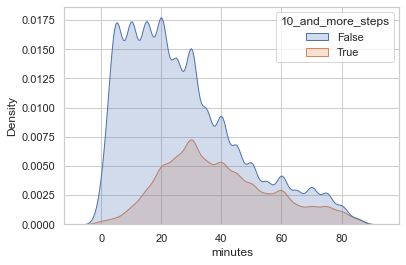

In [6]:
sns.kdeplot(data=cleaned_recipes, x='minutes', fill=True, hue='10_and_more_steps')
plt.show()

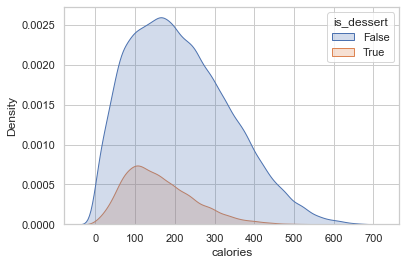

In [7]:
# sns.kdeplot(data=cleaned_recipes[['calories', 'total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']], fill=True)
sns.kdeplot(data=cleaned_recipes, x='calories', fill=True, hue='is_dessert')
plt.show()

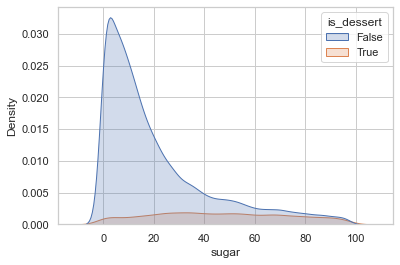

In [8]:
sns.kdeplot(data=cleaned_recipes, x='sugar', fill=True, hue='is_dessert')
plt.show()

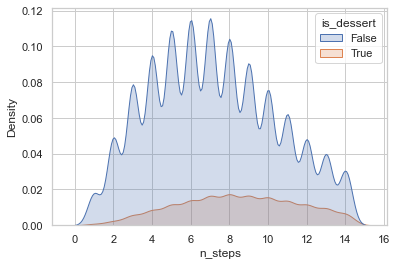

In [9]:
sns.kdeplot(data=cleaned_recipes, x='n_steps', fill=True, hue='is_dessert')
plt.show()

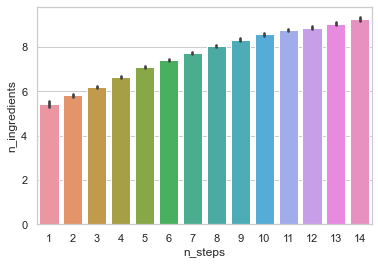

In [10]:
sns.barplot(data=cleaned_recipes, x="n_steps", y="n_ingredients")
plt.show()

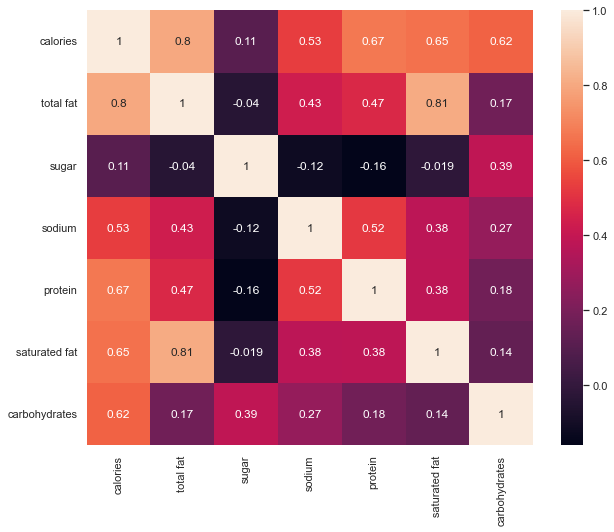

In [11]:
plt.figure(figsize=(10,8))
sns.heatmap(cleaned_recipes[
    ['calories', 'total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']
].corr(), annot=True)
plt.show()

In [12]:
# merge two dfs together
data = cleaned_recipes.merge(raw_interaction, left_on='id', right_on='recipe_id')
data = data.drop(columns='nutrition')
data = data.assign(steps=data['steps'].apply(lambda txt:txt[1:-1].replace("'", "")))
try:
    sia = SentimentIntensityAnalyzer()
    def sentiment_score(review):
        scores = [
            sia.polarity_scores(sentence)["compound"]
            for sentence in nltk.sent_tokenize(review)
        ]
        return np.mean(scores)

    data = data.dropna()
    data = data.assign(sentiment = data['review'].apply(sentiment_score))
    data_with_zero = data[data['rating'] == 0]
    data_without_zero = data[data['rating'] != 0]

    lr = LinearRegression()
    lr.fit(data_without_zero['sentiment'].to_numpy().reshape(-1,1), data_without_zero['rating'].to_numpy().reshape(-1,1))
    data_with_zero = data_with_zero.assign(rating = np.round(lr.predict(data_with_zero['sentiment'].to_numpy().reshape(-1,1))))

    data = pd.concat([data_without_zero, data_with_zero], axis=0)
    data.head()
except:
    print("Please rerun this cell")
    nltk.download('vader_lexicon')

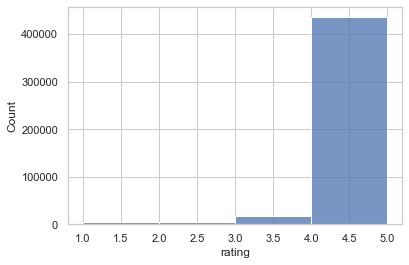

In [13]:
sns.histplot(data=data, x='rating', binwidth=1)
plt.show()

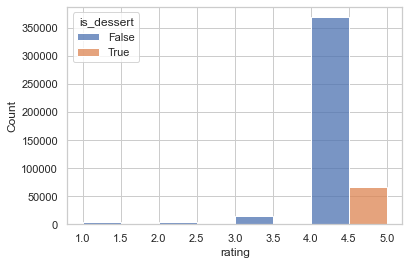

In [14]:
sns.histplot(data=data, hue='is_dessert', x='rating', multiple="dodge", binwidth=1)
plt.show()

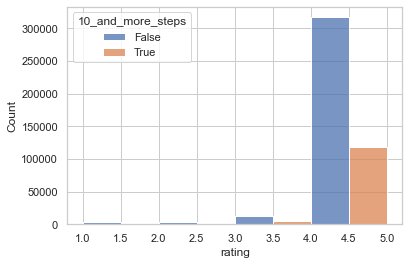

In [15]:
sns.histplot(data=data, hue='10_and_more_steps', x='rating', multiple="dodge", binwidth=1)
plt.show()

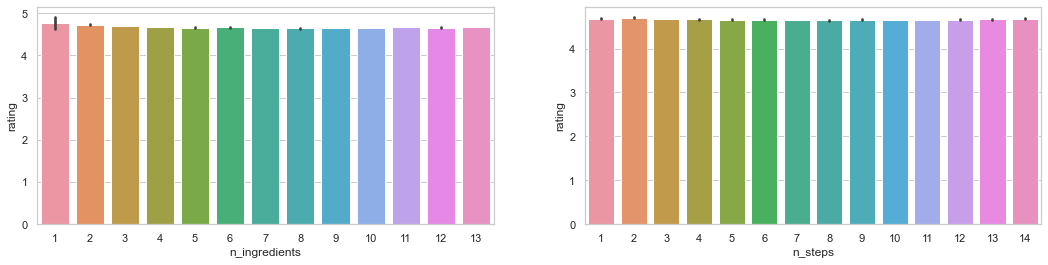

In [16]:
fig,ax = plt.subplots(1,2, figsize=(18,4))
sns.barplot(data=data, x="n_ingredients", y="rating", ax=ax[0])
sns.barplot(data=data, x="n_steps", y="rating", ax=ax[1])
plt.show()

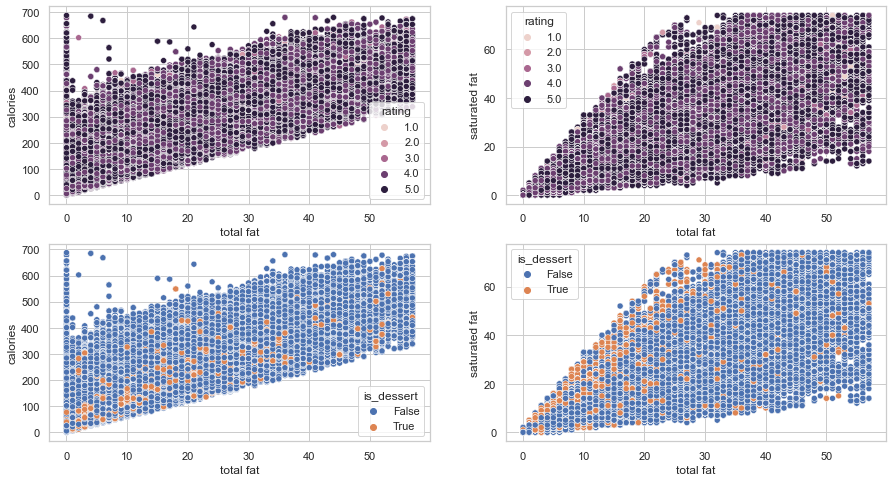

In [17]:
# takes a while to plot because there are lots of points
fig,ax = plt.subplots(2,2,figsize=(15,8))
sns.scatterplot(data=data, x="total fat", y="calories", hue="rating", ax=ax[0, 0])
sns.scatterplot(data=data, x="total fat", y="saturated fat", hue="rating", ax=ax[0, 1])
sns.scatterplot(data=data, x="total fat", y="calories", hue="is_dessert", ax=ax[1, 0])
sns.scatterplot(data=data, x="total fat", y="saturated fat", hue="is_dessert", ax=ax[1, 1])
plt.show()

In [18]:
np.random.seed(1)
is_adj = lambda pos: pos[:2] == 'JJ'

def extract_adj(txt):
    tokenized = nltk.word_tokenize(txt)
    adj = [word for (word, pos) in nltk.pos_tag(tokenized) if is_adj(pos)]
    return adj

In [19]:
def generate_word_cloud():
    word_cloud = []

    unique_ratings = sorted(data["rating"].unique())
    for rating in unique_ratings:
        temp_text = data[data["rating"]== rating]["review"]
        rand_idx = np.random.choice(range(0, len(temp_text)), 2500, replace=False)
        temp_text = temp_text.iloc[rand_idx]
        collapsed_temp_text = temp_text.str.cat(sep=' ')
        word_cloud += [extract_adj(collapsed_temp_text)]

    word_clouds = []
    for sub in word_cloud:
        counter = Counter(sub)
        most_occur = counter.most_common(100)
        word_clouds += [most_occur]

    word_clouds = [wc[3:-3] for wc in word_clouds]
    
    word_clouds = [{t[0]:t[1] for t in rate} for rate in word_clouds]

    for idx, rate in enumerate(word_clouds[1:]):
        wordcloud = WordCloud()
        wordcloud.generate_from_frequencies(frequencies=rate)
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title("Word Cloud For Rate " + str(idx+1))
        plt.axis("off")
        plt.show()

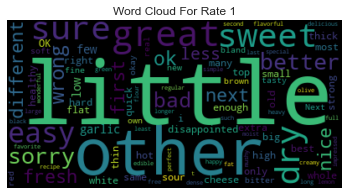

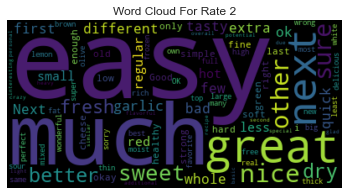

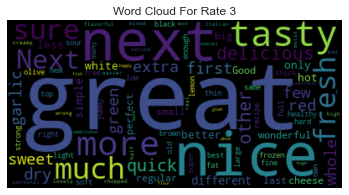

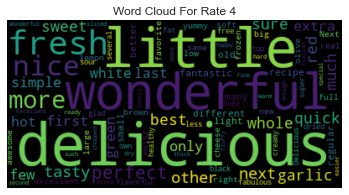

In [20]:
try:
    generate_word_cloud()
except:
    print("please rerun this cell")
    nltk.download('punkt')
    nltk.download('averaged_perceptron_tagger')

## Predictive Models

In [21]:
def mse(preds, actuals):
    return np.mean(
        (np.array(preds).reshape(1, -1) - np.array(actuals).reshape(1, -1))**2
    )

def accuracy(preds, actuals):
    return np.mean(
        np.array(preds).reshape(1, -1) == np.array(actuals).reshape(1, -1)
    )

# Rating Prediction

In [22]:
df = data[['user_id', 'recipe_id', 'rating']]
X_train, X_test = train_test_split(df.to_numpy(), train_size=0.25, random_state=58, shuffle=True)
X_train, X_test = pd.DataFrame(X_train, columns=['user_id', 'recipe_id', 'rating']), pd.DataFrame(X_test, columns=['user_id', 'recipe_id', 'rating'])
baseline_train_data = Dataset.load_from_df(X_train, reader=Reader(rating_scale=(0,5)))
train_data = baseline_train_data.build_full_trainset()


baseline_param = {
    'random_state': 58,
    'n_epochs': 55,
    'lr_all': 0.004,
    'lr_bu': 0.004,
    'lr_bi': 0.002,
    'lr_yj': 0.008,
    'reg_all': 0.3,
    'reg_bu': 0.235,
    'reg_bi': 0.3,
    'reg_yj': 0.2,
    'n_factors': 3
    }

baseline_model = SVDpp(
    random_state=baseline_param['random_state'], 
    n_epochs=baseline_param['n_epochs'], 
    lr_all=baseline_param['lr_all'], 
    lr_bu=baseline_param['lr_bu'], 
    lr_bi=baseline_param['lr_bi'], 
    lr_yj=baseline_param['lr_yj'],
    reg_all=baseline_param['reg_all'], 
    reg_bu=baseline_param['reg_bu'], 
    reg_bi=baseline_param['reg_bi'], 
    reg_yj=baseline_param['reg_yj'],
    n_factors=baseline_param['n_factors']
    )

baseline_model.fit(train_data)

preds = np.array(X_test[['user_id', 'recipe_id']].apply(lambda x: baseline_model.predict(x[0], x[1]).est, axis=1))
actuals = np.array(X_test['rating'])
print(f"Testing MSE for this baseline model is {mse(preds, actuals)}.")

Testing MSE for this baseline model is 0.45694677287548896.


In [23]:
lr_X_train, lr_X_test = train_test_split(data, train_size=0.25, random_state=58, shuffle=True)
lr = LinearRegression()
lr.fit(lr_X_train['sentiment'].to_numpy().reshape(-1,1), lr_X_train['rating'].to_numpy().reshape(-1,1))
lr_pred = lr.predict(lr_X_test['sentiment'].to_numpy().reshape(-1,1))
lr_pred = lr_pred.flatten()
final_pred = (preds + lr_pred)/2
print(f"Testing MSE for this weighted model is {mse(X_test['rating'], final_pred)}.")

Testing MSE for this weighted model is 0.4309796428642792.


# Desserts Prediction

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data[['total fat', 'saturated fat', 'sugar']], data[['is_dessert']])
clf = RandomForestClassifier(
    max_depth=7, 
    random_state=7, 
    criterion='entropy', 
    n_estimators=7, 
    max_features='log2')
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
actuals = y_test.to_numpy().reshape(1,-1)[0]
print(f"Testing Accuracy for this model is {accuracy(preds, actuals)}.")

Testing Accuracy for this model is 0.8615427206976503.
